In [1]:
# imports
import requests
import json
import csv
import time
import datetime
from string import Template
from Config import *
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Variables
headers = {"Authorization": API_TOKEN}
min_stars = 237
max_stars = 10000
last_activity = 90 # within the last __ days
created = 364 * 4 # within the last __ days
min_pull_num = 0 # amount of pull requests a repository needs
watchers = 0 # amount of watchers a repository needs

In [4]:
# Builds the query filter string compatible to github
def query_filter( min_stars, last_activity, created ):
    date_last_act = datetime.datetime.now() - datetime.timedelta( days=last_activity )
    date_created = datetime.datetime.now() - datetime.timedelta( days=created )
    stars = f'{min_stars}..1000'

    return f'is:public archived:false fork:false stars:{stars} pushed:20{date_last_act:%y-%m-%d}..* created:20{date_created:%y-%m-%d}..* sort:stars-asc'

In [5]:
# Funtion that uses requests.post to make the API call
def run_query(query, variables):
    request = requests.post('https://api.github.com/graphql', 
                            json={'query': query, 'variables' : variables}, headers=headers)
    #if request.status_code == 200:
        
    if 'Retry-After' in request.headers:  # reached retry limit
        print(f'[WAITING] for {request.headers["Retry-After"]} seconds before continuing...', end=' ')
        time.sleep(int(request.headers['Retry-After']))

    return request.json()
    #else:
    #    raise Exception(f'ERROR [{request.status_code}]: Query failed to execute...\nRESPONSE: {request.text}')

In [6]:
end_cursor = ""
query_string = query_filter( min_stars, last_activity, created)
variables = {
    "query_string" : query_string,
    "end_cursor" : end_cursor,
    "repositoriesPerPage" : 1 # from 1 to 100
}

In [7]:
# setups the github graphql queries
def setup_query( variables, end_cursor ) :
    variables['end_cursor'] = end_cursor
    query = '''
    query($query_string : String!, $repositoriesPerPage : Int) {
        rateLimit{
            cost
            remaining
            resetAt
        }
        search(query: $query_string, type: REPOSITORY, first: $repositoriesPerPage) {
            pageInfo {
                hasNextPage
                endCursor
            }
            repositoryCount
            nodes {
                ... on Repository {
                    id
                    name
                    owner {
                        login
                    }
                    createdAt
                    isMirror
                    isFork
                    diskUsage
                    primaryLanguage {
                        name
                    }
                    languages(first:100) {
                        totalCount
                        nodes {
                            name
                        }
                    }
                    contributors : mentionableUsers {
                        totalCount
                    }
                    watchers {
                        totalCount
                    }
                    stargazers {
                        totalCount
                    }
                    forkCount
                    issues {
                        totalCount
                    }
                    commits : defaultBranchRef {
                        target {
                            ... on Commit {
                                history {
                                    totalCount
                                }
                            }
                        }
                    }
                    pullRequests {
                        totalCount
                    }
                    releases {
                        totalCount
                    }
                    licenseInfo {
                        id
                        name
                        pseudoLicense
                    }
                    url
                }
            }
        }
    }'''
    query2 = '''
    query($query_string : String!, $end_cursor : String, $repositoriesPerPage : Int) {
        rateLimit{
            cost
            remaining
            resetAt
        }
        search(query: $query_string, type: REPOSITORY, first: $repositoriesPerPage, after: $end_cursor) {
            pageInfo {
                hasNextPage
                endCursor
            }
            repositoryCount
            nodes {
                ... on Repository {
                    owner {
                        login
                    }
                    id
                    name
                    description
                    createdAt
                    pushedAt
                    isDisabled
                    isMirror
                    isFork
                    isLocked
                    diskUsage
                    primaryLanguage {
                        name
                    }
                    languages(first:100) {
                        totalCount
                        nodes {
                            name
                        }
                    }
                    contributors : mentionableUsers {
                        totalCount
                    }
                    watchers {
                        totalCount
                    }
                    stargazers {
                        totalCount
                    }
                    forkCount
                    issues {
                        totalCount
                    }
                    commits : defaultBranchRef {
                        target {
                            ... on Commit {
                                history {
                                    totalCount
                                }
                            }
                        }
                    }
                    pullRequests {
                        totalCount
                    }
                    releases {
                        totalCount
                    }
                    licenseInfo {
                        id
                        name
                        pseudoLicense
                    }
                    url
                }
            }
        }
    }'''
    if(end_cursor == "") : return (query, variables)
    else : return (query2, variables)

In [8]:
# Runs the query and iterates through all pages of repositories
def iterate_queries( conn, create_dict_method ):

    end_cursor = ""
    end_cursor_string = ""
    hasNextPage = True
    index = 0
    
    ai = 1 # slow start: 1, 2, 4, 8 (max)
    md = 0.5
    
    print("[WORKING] Running script to collect all repositories. ")
    while( hasNextPage ):
        print("[WORKING] On page " + str(index))
        query = setup_query( variables, end_cursor )
        result = run_query( query[0], query[1] )
        #print(json.dumps(result))
        
        if 'errors' in result:
            if 'timeout' in result['errors'][0]['message']:  # reached timeout
                variables['repositoriesPerPage'] = int(max(1, variables['repositoriesPerPage'] * md))  # using AIMD
                ai = 1  # resetting slow start
                print('[WORKING] Timeout! - Ressting page size to : ' + 
                      str(variables['repositoriesPerPage']))
            else:  # some unexpected error.
                print(result['errors'])
                exit(1)
        
        if 'data' in result and result['data']:
            
            #print(json.dumps(result))
                      
            insert_repositories( conn, result, create_dict_method )

            if(result['data']['search']['nodes']):
                stars = result['data']['search']['nodes'][-1]['stargazers']['totalCount']
            
            try:
                # if there is a next page, update the endcursor string and continue loop
                if( result["data"]["search"]["pageInfo"]["hasNextPage"] ):
                    end_cursor = result["data"]["search"]["pageInfo"]["endCursor"]
                    
                    variables['repositoriesPerPage'] = min(100, variables['repositoriesPerPage'] + ai)  # using AIMD
                    print("[WORKING] New reposPerPage set to : " + str(variables['repositoriesPerPage']))
                    ai = min(8, ai * 2)  # slow start
                    #end_cursor_string = f', after:"{end_cursor}"'
                else:
                    if(result['data']['search']['repositoryCount'] > 1000) :
                        print('[WORKING] We reached the limit of 1,000 repositories.')
                        variables['query_string'] = query_filter(stars, last_activity, created)  # some overlap to accommodate changes in stars
                        print('[WORKING] New selected star value is : ' + str(stars))
                        end_cursor = ""
                    else :
                        hasNextPage = False
                        end_cursor = ""
                        print(json.dumps(result))
            except KeyError:
                print("[WORKING] No next page. ")
                break 

            index += 1
        time.sleep(1)

In [9]:
def create_repo_tuple( node ) :
    commits = 0
    if(node["commits"]["target"]["history"]["totalCount"] != None) :
        commits = node["commits"]["target"]["history"]["totalCount"]
        
    primaryLanguage = "null"
    if(node["primaryLanguage"] != None) :
        primaryLanguage = node["primaryLanguage"]["name"]
        
    license_id = "0"
    license_name = "null"
    pseudoLicense = False
    if(node["licenseInfo"] != None) :
        license_id = node["licenseInfo"]["id"]
        license_name = node["licenseInfo"]["name"]
        pseudoLicense = node["licenseInfo"]["pseudoLicense"]
        
    return (
    node["id"], 
    node["name"], 
    node["owner"]["login"], 
    node["createdAt"], 
    node["isMirror"], 
    node["isFork"], 
    node["diskUsage"], 
    primaryLanguage,
    node["contributors"]["totalCount"], 
    node["watchers"]["totalCount"], 
    node["stargazers"]["totalCount"], 
    node["forkCount"], 
    node["issues"]["totalCount"], 
    commits, 
    node["pullRequests"]["totalCount"], 
    node["releases"]["totalCount"],
    license_id, 
    license_name, 
    pseudoLicense, 
    node["url"]
    )

In [10]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
        
    return conn

In [11]:
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [12]:
# insert repository tuples into the sqlite database
def insert_repositories( conn, result, create_dict_method ):
    
    data_list = []
    nodes = result["data"]["search"]["nodes"]
    for node in nodes:
        data_list.append( create_dict_method( node ) )
    
    """
    Create a new repository into the repository table
    :param conn:
    :param repository:
    :return: project id
    """
    sql = """INSERT or IGNORE INTO repositories (id, name, owner, start_date, isMirror, isFork, diskUsage, 
                     primaryLanguage, numContributors, watchers, stars, forks, issues, commits, 
                     pullRequests, releases, license_id, license_name, pseudoLicense, url) VALUES
                     (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""
    
    cur = conn.cursor()
    cur.executemany(sql, data_list)
    conn.commit()
    print("[SUCCESS] Inserted repos into the database. ")
    cur.close()
    return cur.lastrowid

In [13]:
# name of the sqlite file
database = r".\databases\github_data.db"

# create a database connection
conn = create_connection(database)

In [14]:
# sql for creating the repos table
sql_create_repos_table = """CREATE TABLE IF NOT EXISTS repositories (
                                        id text PRIMARY KEY NOT NULL,
                                        name text NOT NULL,
                                        owner text NOT NULL,
                                        start_date text NOT NULL,
                                        isMirror boolean NOT NULL,
                                        isFork boolean NOT NULL,
                                        diskUsage int NOT NULL,
                                        primaryLanguage text NOT NULL,
                                        numContributors int NOT NULL,
                                        watchers int NOT NULL,
                                        stars int NOT NULL,
                                        forks int NOT NULL,
                                        issues int NOT NULL,
                                        commits int NOT NULL,
                                        pullRequests int NOT NULL,
                                        releases int NOT NULL,
                                        license_id text NOT NULL,
                                        license_name text NOT NULL,
                                        pseudoLicense boolean NOT NULL,
                                        url text NOT NULL
                                    ); """

with conn:
    create_table(conn, sql_create_repos_table)

In [15]:
# when conn is valid
#with conn:
    # run query to find all repositories
    # pass in the repository tuple builder
    # insert the tuple into the database
    # iterate_queries( conn, create_repo_tuple )

['0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.01' '0.01' '0.01' '0.01'
 '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01'
 '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01'
 '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01'
 '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01' '0.01'
 '0.02' '0.02' '0.02' '0.02' '0.02' '0.02' '0.02' '0.02' '0.02' '0.02'
 '0.02' '0.02' '0.02' '0.02' '0.02' '0.03' '0.03' '0.03' '0.03' '0.03'
 '0.03' '0.04' '0.04' '0.04' '0.04' '0.04' '0.04' '0.04' '0.04' '0.05'
 '0.05' '0.05' '0.05' '0.06' '0.06' '0.07' '0.07' '0.07' '0.07' '0.07'
 '0.07' '0.08' '0.09' '0.09' '0.1' '0.11' '0.12' '0.15' '0.17' '0.18'
 '0.23' '0.25' '0.26' '0.29' '0.3' '0.32' '0.32' '0.37' '0.38' '0.45'
 '

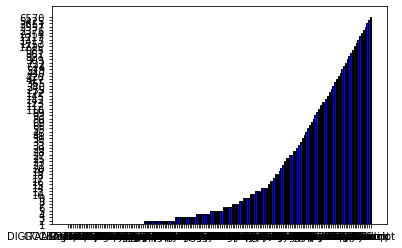

In [17]:
sql_get_num_lang = """SELECT MIN(id) AS id, primaryLanguage, count(*), round(100*(count(*) / 37925.0), 2)
                    FROM repositories 
                    GROUP BY primaryLanguage 
                    ORDER BY count(primaryLanguage)""" 
c = conn.cursor()
result = c.execute(sql_get_num_lang)
rows = c.fetchall()
rows = np.array(rows)
print(rows[:,3])

plt.bar(x=rows[:,1], height=rows[:,2], color='blue', edgecolor='black')
plt.show()
